In [1]:
import imp
import time
import argparse
import numpy as np
import torch
torch.set_printoptions(threshold=10000)
from torch_geometric.datasets import Planetoid,Reddit2,Flickr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated, clu_prune_unrelated_edge
import scipy.sparse as sp
from torch_geometric.utils import subgraph
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=12, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='ogbn-arxiv', 
                    help='Dataset',
                    choices=['Cora','Pubmed','Flickr','ogbn-arxiv','Citeseer','Reddit2'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=128,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=2)
parser.add_argument('--k', type=int, default=100)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=1000, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--rec_epochs', type=int,  default=30, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=400, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--use_vs_number', action='store_true', default=True,
                    help="if use detailed number to decide Vs")
parser.add_argument('--vs_ratio', type=float, default=0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--range', type=float, default=1.0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--vs_number', type=int, default=565,
                    help="number of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="none",
                    choices=['prune', 'isolate', 'none','reconstruct'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.8,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_target', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_ood', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_targetclass', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--outter_size', type=int, default=4096,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=100,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.8,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=1,
                    help="Weight of cluster distance")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GCN',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=2,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

/tmp/ipykernel_1770751/2778829873.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(cuda=True, dataset='ogbn-arxiv', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=565, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [2]:
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    from ogb.nodeproppred import PygNodePropPredDataset
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
    
if(args.dataset == 'Reddit2'):
    num_nodes_to_sample = 20000  # Adjust this based on your needs

    # Randomly select a subset of nodes
    sampled_nodes = torch.randint(data.num_nodes, (num_nodes_to_sample,), device=device)

    # Perform subgraph sampling
    edge,_ = subgraph(sampled_nodes, data.edge_index)
    data.edge_index = edge

In [3]:
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

In [4]:
from sklearn_extra import cluster
from models.backdoor import Backdoor
from models.construct import model_construct
import heuristic_selection as hs
from torch.distributions.bernoulli import Bernoulli

# select poisoned target node #

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
if(args.use_vs_number):
    size = args.vs_number
else:
    size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# print("#Attach Nodes:{}".format(size))
assert size>0, 'The number of selected trigger nodes must be larger than 0!'
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = hs.obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'cluster'):
    idx_attach = hs.cluster_distance_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    if(args.dataset == 'Pubmed'):
        idx_attach = hs.cluster_degree_selection_seperate_fixed(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    else:
        idx_attach = hs.cluster_degree_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# print("idx_attach: {}".format(idx_attach))
unlabeled_idx = torch.tensor(list(set(unlabeled_idx.cpu().numpy()) - set(idx_attach.cpu().numpy()))).to(device)
print('number of benign training nodes', len(idx_train))
print('number of poisoned target nodes', len(idx_attach))

# Cora
# idx_attach = torch.tensor([1672, 2399, 1785, 2020, 2013, 1652,  208, 1220, 2128,  446])
# Flicker
idx_attach = torch.tensor([151986, 162467,  44926,  23940,  72501,  13300,  22065, 147153,  79242,
        128143,  93465,  63507,  73972,  73044,  56937,  88754, 163842, 119362,
         54554,  33519,   8154,  16049, 113091, 156331,  35927, 152431,  38080,
        168947, 121840, 101165,  34467, 130677, 127703, 162722,   4875,  95491,
        148529,  78072, 126281,  59601,  54103, 107477,  51951,  10138,  10104,
         26393,  18876, 151911,  73699, 122090, 149541,   7918,  23625,  54054,
        165054,  90478, 130766, 106047,  62056, 152543, 100119,  62343, 119437,
        129228, 130514,  12459,  58483,  35161,  27651,  77539,  49360,  43087,
         51852,  84642, 162577, 108656,  81292,  49283,  70860,  49404, 141270,
         36926, 101724,  14727,  12525,  19995, 162207,  69782, 127237,   8541,
         83147, 131520,  97803, 109806, 145193, 118680,  20924, 131955, 106455,
        129401,  58891, 116300,  34079,    224,   3172,  88160, 109185, 110668,
        103248,  95078, 154019, 168817,   3771,  18207, 154860,  26834,  11175,
         63122,  47747,  80305, 102581,  82265, 117214, 132492, 137535, 122891,
        164548, 100623,  17308, 153845,  91474, 142746,  85505,  97061, 152602,
        116420,  15941, 152529,  19807,  15146, 148629, 162255, 138185,  96655,
         71909,  25179,  34595, 147363,  64609,  67502,   8161, 136765, 110630,
         11895, 158529,   5181,  90008,  16843,  62749,  33553,  15212,  24861,
        160062,  72270,  25230,  76515,  27120, 152018,  95828, 124173,  80523,
         28845,  84596,  56397,     63, 164765, 140751,  37912,  47903,  69429,
        132506,  66631, 153695,  61748,  18334,  94547,  97448,  58066,   1646,
        158386, 153884,  39628, 129569,  86483, 159823, 109138,  52390,  20765,
         70732,  56531,  14090, 144949,  45603, 136798, 162265,  66578,  42077,
        144225,  23731,  37597,  73034, 115402,  40876, 104645, 123502, 154395,
         47564, 112664, 137399,  62430,   6464, 124696,  50606,  34820, 116196,
        136597, 145708, 105880, 129765,  57303, 155369, 114620,  95339, 103305,
         83091,  68857,  73046,   3183, 149185,  80135, 155473, 164332,  20333,
        139918,  45024, 141475,  91437,   2599,  74708, 160785, 168601,   2915,
         75096,   5486,  69934,   3244, 108649,  69213,  96039,  74594, 144675,
         65112, 157016, 150964,  91340,  17814, 134345,  74006,  51257, 159074,
        165012,  78616,  87458,  26847, 138007, 123722,  44990,  70164, 162681,
        155937,  70939, 115374, 166985, 112764, 144479,  26546,  53170,  25088,
         22346, 157904,  75119,  34364,  98424,  93012, 118674,  89130,  72419,
         29984, 117334,  16483,  19802, 113586,  92262, 140284, 157255, 148016,
         96550,  35893,  73545,  38199,  60664,   1496, 158258, 135970, 121417,
        141379, 164731, 118159,  29576,  75840, 144213,  73692, 104518, 103593,
        126236, 108326,  89873, 140364,  97116, 124288, 121316,   5171, 152926,
          3575,  68393, 168823, 134560,  97522, 147712, 152664,  14128,   3127,
         20516,  85926,  13117, 122575,  59647, 147988,  15855,  38123,  72738,
        123088,  28674, 137800, 151853,  40493, 119849, 125141,  28030,  91051,
        137817,  32725, 151387,  23191, 123924,  94511, 140409,  84661,  57390,
        108036, 146481,  50713,  25635,   8406,  53176,  63767,  10085,  11511,
         10917, 125420, 106500, 122872, 131682, 136815,  70797,   9775, 107485,
         34616,  38800, 157312, 121295, 144843,  53058,  86092,  78410, 129884,
        122432,  34859,  20803,  68352,  62509,  56748,  50567,   7305,  80285,
         47840,  27191, 140932,  97673,  36251, 158464,  28447,  90035,  35878,
         38402, 150487, 147232,   4757,  65803, 136331,  36847, 129631, 125084,
          3774,  93301,  70138, 168983,  39973, 167434,  48993, 134157, 142998,
        142631, 136629,  70597,   5918, 164119, 146838, 129454,  56518, 104736,
         54268, 127712,  51617,  87842, 131931,  75147,  78176, 124529, 144908,
        152599, 109500, 152809, 123358, 113359,  63172,   8716,  47711, 153647,
         78756,  85109, 120331,  54454, 157612,  15584,  48592, 128980, 118870,
        145262,  94992,  28068,  58458,  41115, 103738,   2955,   6977, 108384,
        168777,  70271,  89741, 131143, 109832, 126654,  92179, 100438,  58805,
        103885, 147804, 113577,  21148,  75731, 100325,  68288,  79565,  28340,
          8655,   4924, 156493, 148494,  32973,  44218, 151410,  65225,  69072,
         49753,  72095,  15442, 113605,  69861, 108791, 123205, 121298, 162781,
         82963, 159931,  34136,  10300,  39329, 157392, 107938,    494,  22166,
        109920,  17234,  79404,  53596, 134072,  92397,   2688, 121386, 152968,
         10262,  85337, 112591,   8951,  59919,  34034, 125602,  44639,  97368,
          4367,  40594,  68981, 168198,  69316,  87326,  68237,  35037, 126689,
        154968, 163394, 152383, 103946, 126176,  68477, 112778, 160670, 142487,
        147511, 138188,  27413, 112906,  49367,  76346,  61945])

idx_attach = idx_attach.to(device)

number of benign training nodes 33868
number of poisoned target nodes 565


In [5]:
## trigger generator ##
model = Backdoor(args,device)
model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx, True)

0

In [6]:
test_model = 'GCN'
total_overall_asr = 0
total_overall_ca = 0
args.test_model = test_model
rs = np.random.RandomState(args.seed)
seeds = rs.randint(1000,size=1)
overall_asr = 0
overall_ca = 0

In [7]:
# load poisoned graph #
# poison_x = torch.load('poison_x.pt')
# poison_edge_index = torch.load('poison_edge_index.pt')
# poison_edge_weights = torch.load('poison_edge_weights.pt')
# poison_labels = torch.load('poison_labels.pt')
poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_x_arxiv.pt')
poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_index_arxiv.pt')
poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_weights_arxiv.pt')
poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_labels_arxiv.pt')
# poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_x.pt')
# poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_index.pt')
# poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_weights.pt')
# poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_labels.pt')

In [8]:
print(args)

mask = data.y[idx_attach] != args.target_class
mask = mask.to(device)

## only attack those has groud truth labels != target_class ##
idx_attach = idx_attach[(data.y[idx_attach] != args.target_class).nonzero().flatten()]

bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
# test_model = model_construct(args,args.test_model,data,device).to(device) 
known_nodes = torch.cat([idx_train,idx_attach]).to(device)
predictions = []
# edge weight for clean edge_index, may use later #
edge_weight = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)


Namespace(cuda=True, dataset='ogbn-arxiv', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=2, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=565, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [9]:
mask.sum()

tensor(544, device='cuda:2')

In [10]:
print(data.y[idx_attach])
# idx_attach is selected target node #
print(poison_labels[idx_attach])

tensor([24, 24,  8, 30, 10, 28, 28, 37,  4, 24, 30, 24,  5, 24, 24,  5, 22,  8,
         4, 24, 28, 36, 28, 16, 34, 10, 16, 24, 37, 24, 24,  7, 10, 38, 28,  6,
        16, 10,  8, 24, 28, 23, 10, 16, 28, 28, 30, 22,  4,  4, 24, 13, 28, 28,
         1, 28, 30, 16, 16, 16, 34, 14, 27, 16,  6, 16, 28, 28, 28,  4,  3, 24,
        23, 24, 34, 34, 16,  1, 39, 30, 16, 38, 30, 34, 24, 30, 34, 16, 36, 23,
        27, 37,  9,  4, 24, 19, 28, 34, 16, 28, 10, 15, 24, 24,  9, 28, 16, 19,
         4, 16,  9, 24, 23, 23, 31, 22,  8, 33, 28, 24, 24, 24,  8,  9, 17, 16,
        13, 28, 13, 28, 16, 28, 16, 10, 30, 30, 16, 24, 28,  6, 10, 28, 30, 28,
        16, 16, 39, 28,  9, 34, 24, 24, 23,  0, 25, 16, 16, 30, 36, 28,  4, 16,
         3, 24,  9,  9,  8, 24,  5, 13, 19, 24, 30, 31, 24, 20,  5, 19, 17, 16,
        34, 19, 21, 19, 28, 10,  8, 16, 34,  8, 37, 24,  4, 37, 28, 16, 28,  4,
        16, 26, 16, 30, 24, 19,  8, 24, 36,  4, 24,  5, 31, 19, 28, 16, 23, 30,
         9, 24, 33, 23, 30, 34, 34, 10, 

In [11]:
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean, x = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))

accuracy on poisoned target nodes: 0.9963


In [12]:
output_clean[idx_attach].argmax(dim=1)

tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        16,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2, 

In [13]:
# test backdoored model for comparison #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.9926
Flip ASR: 0.9924/16482 nodes
CA: 0.6720


In [14]:
# edge drop #
def sample_noise_all(edge_index, edge_weight,device):
    noisy_edge_index = edge_index.clone().detach()
    if(edge_weight == None):
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    else:
        noisy_edge_weight = edge_weight.clone().detach()
    # # rand_noise_data = copy.deepcopy(data)
    # rand_noise_data.edge_weight = torch.ones([rand_noise_data.edge_index.shape[1],]).to(device)
    m = Bernoulli(torch.tensor([0.1]).to(device))
    mask = m.sample(noisy_edge_weight.shape).squeeze(-1).int()
    # print('mask',mask)
    rand_inputs = torch.randint_like(noisy_edge_weight, low=0, high=2).squeeze().int().to(device)
    # print(rand_noise_data.edge_weight.shape,mask.shape)
    noisy_edge_weight = noisy_edge_weight * mask #+ rand_inputs * (1-mask)
        
    if(noisy_edge_weight!=None):
        noisy_edge_index = noisy_edge_index[:,noisy_edge_weight.nonzero().flatten().long()]
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    return noisy_edge_index, noisy_edge_weight

In [15]:
# test robustness #
for i in range(200):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output, x = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

In [16]:
# torch.argmax(predictions[8][23868])

In [17]:
epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([34350, 34324, 34390, 34307, 34224, 34308, 34373, 33990, 34226, 33925,
        34106, 34176, 33888, 33927, 34240, 33986, 34366, 34052, 34381, 34023,
        34306, 34270, 34279, 34011, 34188, 34163, 33973, 34282, 34213, 34055,
        34318, 34274, 34169, 34175, 34081, 34262, 34271, 33922, 34140, 34128,
        33912, 34124, 34248, 34057, 33951, 34358, 34062, 34396, 34064, 34288,
        33908, 34159, 34344, 34354, 34114, 33964, 34289, 34184, 33931, 34068,
        33904, 34189, 33902, 34071, 34389, 34405, 34178, 33920, 33997, 34217,
        34410, 33984, 34132, 34219, 34072, 34266, 33993, 34080, 34272, 33988,
        33901, 34117, 34148, 34069, 34111, 34152, 33868, 34196, 34233, 34218,
        34171, 34253, 34287, 34118, 34246, 34004, 34398, 33871, 34263, 34394,
        34151, 34131, 34141, 34249, 33944, 33885, 34173, 34326, 34134, 33897,
        34259, 34034, 34204, 34223, 34101, 34383, 34309, 34193, 34303, 34102,
        33895, 33938, 34332, 33870, 34040, 

/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [18]:
torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[0][:mask.sum()]

tensor([84.6760, 83.6187, 83.3425, 80.2381, 80.2362, 79.5940, 78.8586, 78.7171,
        78.4552, 77.7562, 77.7548, 77.6518, 76.7567, 76.1506, 75.7020, 74.8627,
        74.5611, 73.5618, 73.4017, 73.0981, 73.0784, 72.7927, 72.6012, 72.5411,
        72.4175, 71.9884, 71.7857, 71.0345, 70.9769, 70.8887, 70.5353, 70.5339,
        70.3954, 70.1649, 70.0182, 69.8740, 69.8256, 69.7561, 69.3836, 68.9722,
        68.8353, 68.7368, 68.6310, 68.5413, 67.9345, 67.8642, 67.1525, 66.9611,
        66.3435, 66.1687, 66.0306, 66.0264, 66.0057, 65.7101, 65.6074, 65.3121,
        65.2361, 65.2106, 65.1114, 64.3413, 64.2833, 63.8644, 63.5896, 63.5464,
        63.5123, 63.5071, 63.4520, 63.1823, 63.1316, 63.0732, 63.0413, 62.8442,
        62.6533, 62.5929, 62.4272, 62.3901, 62.2289, 60.7358, 60.3375, 59.8137,
        59.5424, 59.3395, 59.2885, 59.2530, 58.9390, 58.9295, 58.6685, 58.2811,
        58.2663, 57.9700, 57.8905, 57.7375, 57.6511, 57.2194, 57.1573, 57.1179,
        56.9402, 56.8697, 56.7841, 56.65

In [19]:
print(len(ori_predict))
mask.sum()

34412


tensor(544, device='cuda:2')

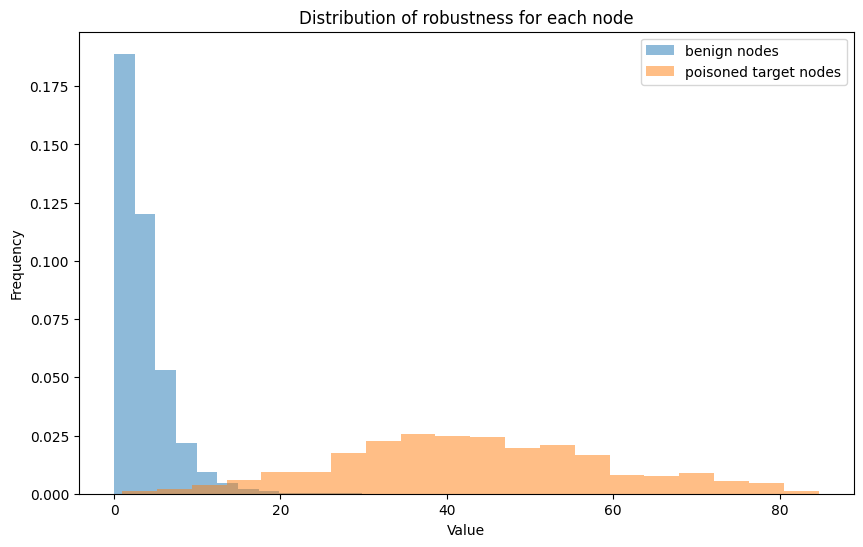

In [20]:


# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(40, 24))
##### benign nodes #####
plt.hist(a_excluding_last_40, bins=20, alpha=0.5, label='benign nodes', density=True)
##### poisoned success nodes #####
plt.hist(a_last_40, bins=20, alpha=0.5, label='poisoned target nodes',density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of robustness for each node')
plt.savefig('a.jpg')
plt.show()

In [21]:
output_clean[idx_attach].argmax(dim=1)
output_clean = torch.exp(output_clean)

In [22]:
import torch
from torch_geometric.utils import k_hop_subgraph
epsilon = 1e-8

print(output_clean[idx_attach].argmax(dim=1))


from torch_geometric.utils import k_hop_subgraph
result_clean=[]
for node_id in idx_train[:300]:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        result_clean.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_clean)

tensor([ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        16,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  2,  2,  2,  2,  2, 

In [23]:
result_trigger = []
for node_id in idx_attach:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
        if loop_edges[:,i][1]>len(data.x):
            # print(loop_edges[:,i][1])
            result_trigger.append(deviation.mean().item())
            
        # else:
        # print(deviation.mean().item())
            # result_clean.append(deviation.mean().item())

        # result_trigger.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_trigger)

[0.21461306512355804, 0.2615654170513153, 0.19127996265888214, 0.2422286719083786, 0.2934282422065735, 0.22389435768127441, 0.20501795411109924, 0.170529305934906, 0.22319863736629486, 0.19729745388031006, 0.2042435258626938, 0.15002340078353882, 0.22577093541622162, 0.17851947247982025, 0.18025076389312744, 0.041773874312639236, 0.27401408553123474, 0.2926959693431854, 0.2091800421476364, 0.24862530827522278, 0.0856967493891716, 0.1705678403377533, 0.20429883897304535, 0.1543503850698471, 0.07645785063505173, 0.18162739276885986, 0.20269861817359924, 0.1858331561088562, 0.2632058262825012, 0.2117614597082138, 0.13852249085903168, 0.11357345432043076, 0.2173186093568802, 0.3331073224544525, 0.1438348889350891, 0.37414130568504333, 0.1960221379995346, 0.14107851684093475, 0.13447903096675873, 0.3172384798526764, 0.1632266491651535, 0.1326812356710434, 0.2585127353668213, 0.21760086715221405, 0.27312764525413513, 0.15945002436637878, 0.01552989799529314, 0.1524263620376587, 0.15189181268

In [24]:
print(len(result_trigger))
print(min(result_trigger))
print(max(result_trigger))
print(sorted(result_trigger,reverse=True))
print(max(result_clean))
print(sorted(result_clean,reverse=True))

543
0.0002048439346253872
0.4440935254096985
[0.4440935254096985, 0.44019055366516113, 0.4344047009944916, 0.43211570382118225, 0.4285106360912323, 0.4233660399913788, 0.4172205626964569, 0.41059398651123047, 0.40861088037490845, 0.40190163254737854, 0.3990641236305237, 0.3986470401287079, 0.39674028754234314, 0.3913044035434723, 0.3888581097126007, 0.3867969512939453, 0.38231754302978516, 0.3811855912208557, 0.37937337160110474, 0.37538114190101624, 0.3750844895839691, 0.37414130568504333, 0.368127703666687, 0.3650378882884979, 0.35849103331565857, 0.3584005534648895, 0.35839441418647766, 0.35414811968803406, 0.35240212082862854, 0.35128650069236755, 0.34614571928977966, 0.3451785445213318, 0.34377822279930115, 0.34308061003685, 0.3428548276424408, 0.3420873284339905, 0.3414064645767212, 0.33757483959198, 0.33699682354927063, 0.33634743094444275, 0.3353646695613861, 0.3335929214954376, 0.33342134952545166, 0.33321309089660645, 0.3331073224544525, 0.33274397253990173, 0.325985789299011

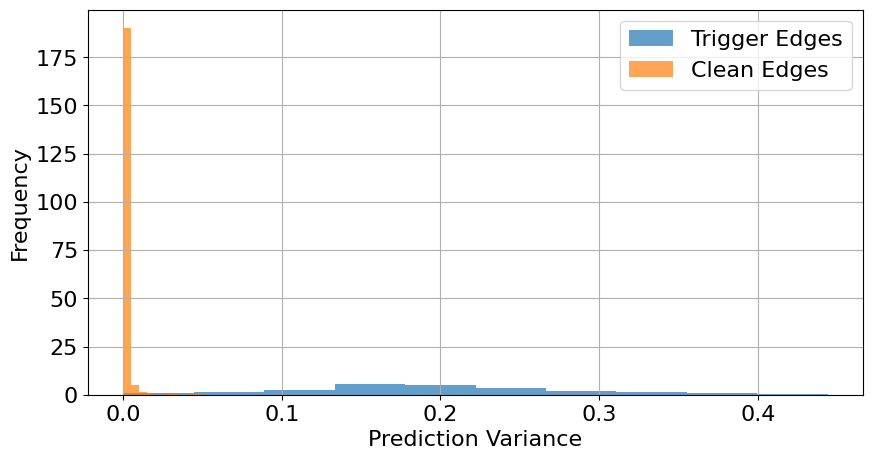

In [25]:
import matplotlib.pyplot as plt

# Ensure you have your data loaded in result_clean and result_trigger
# Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]
# result_trigger = [x for x in result_trigger if x < 0.8 and x>0.2]
# result_clean = [x for x in result_clean if x < 2 and x>0.2]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edge',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edge',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# # plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Prediction Variance')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# # Save the plot before displaying it
# plt.savefig('cora.pdf')

# # Display the plot
# plt.show()
plt.figure(figsize=(10, 5))

plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edges', density=True)
plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edges', density=True)

plt.xlabel('Prediction Variance',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

# Adjust x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)

# Add a caption below the figure
# plt.figtext(0.5, -0.05, 'Comparison of prediction variance due to trigger edges drop and clean edges drop.', wrap=True, horizontalalignment='center', fontsize=14)

# Save the plot before displaying it
plt.savefig('cora.pdf')

# Display the plot
plt.show()

In [26]:
# result_clean=[]
# for node_id in idx_train[:10000]:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
#         result_clean.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_clean)


In [27]:
# result_trigger = []
# for node_id in idx_attach:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
#         if loop_edges[:,i][1]>len(data.x):
#             result_trigger.append(deviation.mean().item())
#         else:
#             print(deviation.mean().item())
#             # result_clean.append(deviation.mean().item())

#         result_trigger.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_trigger)


In [28]:
# import matplotlib.pyplot as plt

# # Ensure you have your data loaded in result_clean and result_trigger
# # Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

In [29]:
poison_labels[idx_attach] = args.target_class

In [30]:
len(idx_attach)

544

In [31]:
## retrain a model on purified graph ##

# labels for target poisoned node before purified #
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust[:400]:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=index_of_less_robust)

## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [32]:
# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# # in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.0000
Flip ASR: 0.0000/16482 nodes
CA: 0.6727


In [36]:
output.argmax(dim=1)[idx_atk]

tensor([22, 22, 22,  ..., 22, 22, 22], device='cuda:2')

In [34]:
correct_class_probs = output[idx_atk, torch.arange(data.y[idx_atk].size(0)), data.y[idx_atk]]

IndexError: too many indices for tensor of dimension 2